In [1]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

import pandas as pd

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

In [2]:
from HFC32_bmimAc_PR import configuration
data = pd.read_csv('R32_bmimAc.csv')

solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [3]:
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False})

m.fs.properties = GenericParameterBlock(default=configuration)

m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m.fs.F101.inlet.flow_mol.fix(1)
m.fs.F101.inlet.temperature.fix(323.15)
m.fs.F101.inlet.pressure.fix(399800)
m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(0.5)

m.fs.properties.PR_kappa_A['bmimAc', 'R32'].fix(-0.56277)
m.fs.properties.PR_kappa_A['R32', 'bmimAc'].fix(-0.03025)
m.fs.properties.PR_kappa_B['bmimAc', 'R32'].fix(0.0)
m.fs.properties.PR_kappa_B['R32', 'bmimAc'].fix(0.0)

# Initialize the flash unit
m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

# Fix the state variables on the state block
# m.fs.F101.inlet.pressure.unfix()
m.fs.F101.inlet.mole_frac_comp[0,'bmimAc'].unfix()

R32_x = np.zeros((len(data)))
P = np.zeros((len(data)))



In [4]:
bmim = np.linspace(data["x_bmimAc"].iloc[6], data["x_bmimAc"].iloc[0], 15)

P = np.zeros((len(bmim)))
P0 = np.zeros((len(bmim)))
R32_x1 = np.zeros((len(bmim)))
m.fs.liq = Param(mutable=True,default=0.040)
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "bmimAc"] == m.fs.liq)

for i in range(len(bmim)-1):
    print(i)
    m.fs.liq = bmim[i]
    a = bmim[i]
    b = 1-(bmim[i])

    P0[i] = 1817227.28*b**2 + 1070035.75*b - 17132.62 
    print(P0[i])

    m.fs.F101.inlet.temperature.fix(298.001)
    m.fs.F101.inlet.pressure.fix(P0[i])
    m.fs.F101.inlet.mole_frac_comp[0,'R32'].fix(1-(bmim[i]-0.05))
    m.fs.F101.inlet.mole_frac_comp[0,'bmimAc'].fix(bmim[i]-0.05)
    m.fs.F101.vap_outlet.temperature.fix(298.001)
    m.fs.F101.vap_outlet.pressure.fix(P0[i])
    m.fs.F101.vap_outlet.pressure.unfix()
    
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
    
    try:
        m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

        status = solver.solve(m, tee = False)

        if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

            R32_x1[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R32']) 
            P[i] = value(m.fs.F101.vap_outlet.pressure[0])

        else:
            print('Infeasible.')
            
    except ValueError:
        
            R32_x1[i] = "NaN"
            P[i] = "NaN"


0
1001246.428028
1
907948.245421182
2
818505.8482398138
3
732919.2364838955
4
651188.4101534268
5
573313.3692484082
6
499294.1137688393
7
429130.64371472003
8
362822.9590860507
9
300371.05988283106
10
241774.94610506122
11
187034.61775274118
12
136150.07482587112
13
89121.31732445056


In [5]:
print(P)
# print(data["pressure"])
# print(R125_x)
# print(data["x_R125"])

[1008819.84173131  900969.63170935  803298.65800126  714310.11787625
  632774.52052901  557674.99665299  488164.87288779  423534.84089934
  363187.10984225  306615.02272065  253386.85601402  203132.86037982
  155534.83412733  110317.67030777       0.        ]


In [6]:
m.fs.F101.report()


Unit : fs.F101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value   : Fixed : Bounds
          Heat Duty : -450.49 : False : (None, None)
    Pressure Change :  21196. : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                            Inlet  Vapor Outlet  Liquid Outlet
    flow_mol               1.0000     0.054739       0.94526  
    mole_frac_comp bmimAc 0.86343   1.0000e-08       0.91343  
    mole_frac_comp R32    0.13657       1.0000      0.086571  
    temperature            298.00       298.00        298.00  
    pressure               89121.   1.1032e+05    1.1032e+05  


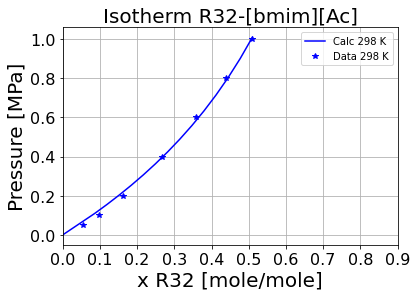

In [7]:
# for i in range(len(P)):
#     P[i] = P[i]*1e6
P1= np.zeros((len(P)))

for i in range(len(P)):
    P1[i] = P[i]/1e6

plt.plot(R32_x1,P1,"b",label="Calc 298 K")  
plt.plot(data["x_R32"][0:7],data["pressure"][0:7]/1e6,"*",color='b',label="Data 298 K")  
plt.title('Isotherm R32-[bmim][Ac]',fontsize=20)
plt.ylabel('Pressure [MPa]',fontsize=20)
plt.xlabel('x R32 [mole/mole]',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
# plt.ylim(0,1.110000)
plt.xlim(0,0.9)
plt.legend(fontsize=10)
# plt.savefig('Isotherm R32-[bmim][PF6]_bin.png', bbox_inches='tight',dpi=300)
plt.show()

In [10]:
df = pd.DataFrame({"P1":P1,"x1":R32_x1})
df.to_csv('P_M1_32_bmimAc.csv')                